In [1]:
from pathlib import Path
import pickle
import math
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, log_loss

sns.set_style("whitegrid")
pd.set_option("display.max_columns", 200)

ROOT = Path(".").resolve()
PREDICTIONS_DIR = ROOT / "outputs"
PLOTS_DIR = ROOT / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
TASK = "mortality_csv"

print("Root:", ROOT)
print("Predictions dir:", PREDICTIONS_DIR)

Root: /home/yk3043@mc.cumc.columbia.edu/EHR-missingness
Predictions dir: /home/yk3043@mc.cumc.columbia.edu/EHR-missingness/outputs


In [2]:
def safe_load_pickle(path: Path):
    try:
        with open(path, "rb") as f:
            return pickle.load(f)
    except Exception as exc:
        print(f"Failed to load {path.name}: {exc}")
        return None


def parse_icl_filename(path: Path, task: str):
    name = path.name
    prefix = f"predictions_{task}_"
    if not (name.startswith(prefix) and name.endswith(".pkl")):
        return None

    stem = name[:-4]  # remove .pkl
    suffix = stem[len(prefix):]
    tokens = suffix.split("_")

    # Expected endings:
    # 1) ..._<exp_missing>_<labs_only>_<include_cot>_iclK_seedS
    # 2) ..._<exp_missing>_<labs_only>_<include_cot>_iclK_<icl_sampling>_seedS
    # 3) either of the above plus optional _cohort-<name>
    # 4) either of the above plus optional _testN suffix (e.g., _seed1_test5)
    test_token = None
    if len(tokens) >= 1 and tokens[-1].startswith("test"):
        test_token = tokens[-1]
        tokens = tokens[:-1]

    if len(tokens) < 6:
        return None

    seed_token = tokens[-1]
    if not seed_token.startswith("seed"):
        return None

    tokens_no_seed = tokens[:-1]

    cohort = None
    if len(tokens_no_seed) >= 1 and tokens_no_seed[-1].startswith("cohort-"):
        cohort = tokens_no_seed[-1].replace("cohort-", "").strip().lower() or None
        tokens_no_seed = tokens_no_seed[:-1]

    if len(tokens_no_seed) < 5:
        return None

    # Optional icl sampling token (e.g., random/stratified/balanced)
    maybe_sampling = tokens_no_seed[-1].strip().lower()
    if len(tokens_no_seed) >= 6 and not tokens_no_seed[-1].startswith("icl"):
        icl_sampling_strategy = maybe_sampling
        icl_token = tokens_no_seed[-2]
        include_cot_token = tokens_no_seed[-3]
        labs_only_token = tokens_no_seed[-4]
        exp_missing_token = tokens_no_seed[-5]
        model = "_".join(tokens_no_seed[:-5])
    else:
        icl_sampling_strategy = None
        icl_token = tokens_no_seed[-1]
        include_cot_token = tokens_no_seed[-2]
        labs_only_token = tokens_no_seed[-3]
        exp_missing_token = tokens_no_seed[-4]
        model = "_".join(tokens_no_seed[:-4])

    if not model:
        return None
    if exp_missing_token not in {"True", "False"}:
        return None
    if labs_only_token not in {"True", "False"}:
        return None
    if include_cot_token not in {"True", "False"}:
        return None
    if not icl_token.startswith("icl"):
        return None

    try:
        icl_num = int(icl_token.replace("icl", ""))
        seed = int(seed_token.replace("seed", ""))
        test_num = int(test_token.replace("test", "")) if test_token else None
    except ValueError:
        return None

    # Keep two fields for icl0 runs:
    # - icl_sampling_strategy: always "none" for zero-shot compatibility in plots
    # - zero_shot_variant: distinguishes plain icl0 ("standard") vs icl0_baseline ("baseline")
    zero_shot_variant = None
    if icl_num == 0:
        raw_zero_shot_token = (icl_sampling_strategy or "").strip().lower()
        if raw_zero_shot_token in {"baseline", "provide_prevalence"}:
            zero_shot_variant = "baseline"
        elif raw_zero_shot_token in {"", "none"}:
            zero_shot_variant = "standard"
        else:
            zero_shot_variant = raw_zero_shot_token
        icl_sampling_strategy = "none"
    elif not icl_sampling_strategy:
        # Backward-compatible default: historical icl>0 files with no strategy token
        # were generated with random selection.
        icl_sampling_strategy = "random"

    return {
        "task": task,
        "model": model,
        "explicit_missingness": exp_missing_token == "True",
        "labs_only": labs_only_token == "True",
        "include_cot_prompt": include_cot_token == "True",
        "icl_num_examples": icl_num,
        "icl_sampling_strategy": icl_sampling_strategy,
        "zero_shot_variant": zero_shot_variant,
        "cohort": cohort,
        "seed": seed,
        "test_num_samples": test_num,
        "path": path,
    }


def strategy_label(explicit_missingness: bool, include_cot_prompt: bool):
    if not explicit_missingness:
        return "Dropped"
    if explicit_missingness and not include_cot_prompt:
        return "Indicator"
    return "Indicator + Inst."


def is_prob(value):
    try:
        x = float(value)
    except Exception:
        return False
    return math.isfinite(x) and 0.0 <= x <= 1.0


def expected_calibration_error(y_true, y_prob, n_bins=10):
    y_true = np.asarray(y_true).astype(float)
    y_prob = np.asarray(y_prob).astype(float)
    bins = np.linspace(0, 1, n_bins + 1)
    bin_ids = np.digitize(y_prob, bins) - 1
    ece = 0.0
    n = len(y_true)

    for b in range(n_bins):
        mask = bin_ids == b
        if not np.any(mask):
            continue
        acc = y_true[mask].mean()
        conf = y_prob[mask].mean()
        ece += (mask.sum() / n) * abs(acc - conf)

    return float(ece)


def compute_binary_metrics(y_true, y_prob, eps=1e-6):
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    y_prob = np.clip(y_prob, eps, 1 - eps)

    if len(np.unique(y_true)) < 2:
        auroc = np.nan
    else:
        auroc = float(roc_auc_score(y_true, y_prob))

    return {
        "n": int(len(y_true)),
        "auroc": auroc,
        "log_loss": float(log_loss(y_true, y_prob)),
        "ece": expected_calibration_error(y_true, y_prob, n_bins=10),
    }

def _model_sort_key(model_name: str):
    s = str(model_name)
    s_lower = s.lower()

    # Prefer numeric size ordering when present (e.g., 1.7B, 4B, 14B, 32B).
    size_match = re.search(r"(\d+(?:\.\d+)?)\s*([bm])\b", s_lower)
    if size_match:
        size_val = float(size_match.group(1))
        unit = size_match.group(2)
        # Convert to "billions" for comparable ordering.
        size_in_b = size_val if unit == "b" else size_val / 1000.0
    else:
        size_in_b = float("inf")

    # Group by family-ish prefix so mixed families still look consistent.
    family = s_lower.split("/")[0] if "/" in s_lower else s_lower.split("-")[0]
    return (family, size_in_b, s_lower)

In [3]:
rows = []
for path in sorted(PREDICTIONS_DIR.glob(f"predictions_{TASK}_*_icl*.pkl")):
    meta = parse_icl_filename(path, TASK)
    if meta is None:
        continue

    pred_dict = safe_load_pickle(path)
    if not isinstance(pred_dict, dict):
        continue

    y_true = []
    y_prob = []
    for _, item in pred_dict.items():
        if not isinstance(item, dict):
            continue
        label = item.get("label")
        if label is None:
            continue

        sample_preds = item.get("prediction_samples")
        valid_sample_preds = []
        if isinstance(sample_preds, list):
            valid_sample_preds = [float(p) for p in sample_preds if is_prob(p)]

        if valid_sample_preds:
            pred = float(np.mean(valid_sample_preds))
        else:
            # Backward-compatible fallback for files without prediction_samples
            single_pred = item.get("prediction")
            if not is_prob(single_pred):
                continue
            pred = float(single_pred)

        y_true.append(int(bool(label)))
        y_prob.append(pred)

    if len(y_true) == 0:
        continue

    metrics = compute_binary_metrics(y_true, y_prob)
    rows.append({
        **meta,
        **metrics,
        "serialization_strategy": strategy_label(
            meta["explicit_missingness"],
            meta["include_cot_prompt"],
        ),
    })

results_df = pd.DataFrame(rows)
if results_df.empty:
    raise RuntimeError("No mortality_csv prediction files found. Check outputs/ and filename pattern.")

In [4]:
zero_shot_strategy_plot = "Standard"
icl_strategy_plot = "Stratified"

/tmp/ipykernel_3016978/398696789.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


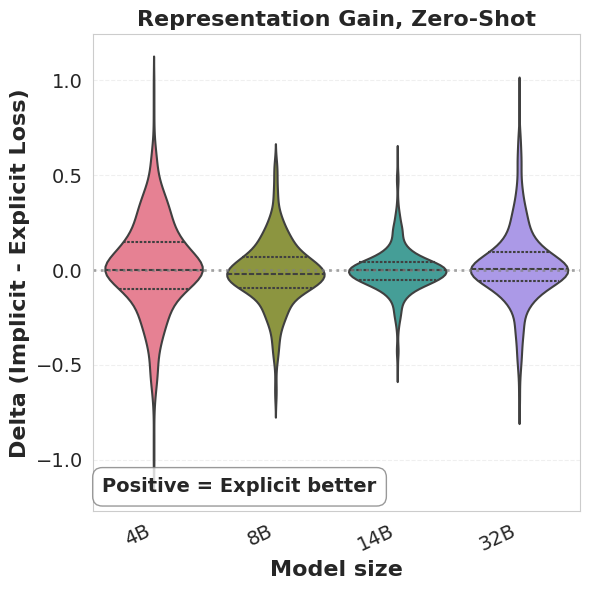

In [5]:
# Violin: delta (log loss improvement) between two prompting strategies, by model size.
# Uses a single chosen context length (e.g. ICL=0). Delta = loss(base) − loss(compare); positive = compare better.
# Requires results_df with path to PKL files (run PKL loading from plot_results_mortality_csv if needed).

if "results_df" not in globals() or not isinstance(results_df, pd.DataFrame) or results_df.empty:
    raise RuntimeError("Run the PKL loading cell first to create results_df (e.g. from plot_results_mortality_csv).")

_vf_icl = 0
_vf_cohort = "ccu"
_vf_strategy_compare = "Indicator"
_vf_zero_shot_strategy = zero_shot_strategy_plot
_vf_strategy_base = "Dropped"

rf_meta = results_df.copy()
if "serialization_strategy" not in rf_meta.columns and "explicit_missingness" in rf_meta.columns and "include_cot_prompt" in rf_meta.columns:
    rf_meta["serialization_strategy"] = rf_meta.apply(
        lambda r: strategy_label(r["explicit_missingness"], r["include_cot_prompt"]), axis=1
    )

def _model_size_label(model_name: str):
    s = str(model_name)
    m = re.search(r"(\d+(?:\.\d+)?)\s*([bB])\b", s)
    if m:
        return f"{m.group(1)}{m.group(2).upper()}"
    return s

eps_vf = 1e-6
def _load_pred_label_vf(path):
    d = safe_load_pickle(path)
    if not isinstance(d, dict):
        return None
    out = {}
    for sid, item in d.items():
        if not isinstance(item, dict) or item.get("label") is None:
            continue
        y = int(bool(item.get("label")))
        sp = item.get("prediction_samples")
        probs = [float(p) for p in sp if is_prob(p)] if isinstance(sp, list) else []
        p = float(np.mean(probs)) if probs else item.get("prediction")
        if not is_prob(p):
            continue
        out[sid] = (np.clip(float(p), eps_vf, 1 - eps_vf), y)
    return out

rf = rf_meta.copy()
rf["_ck"] = rf["cohort"].fillna("all").astype(str).str.lower()
if _vf_cohort is not None:
    rf = rf[rf["_ck"] == str(_vf_cohort).strip().lower()]
rf = rf[rf["icl_num_examples"] == _vf_icl]
rf = rf[rf["serialization_strategy"].isin([_vf_strategy_compare, _vf_strategy_base])]

# For zero-shot (ICL=0), filter by zero_shot_variant if specified
if _vf_icl == 0 and _vf_zero_shot_strategy is not None:
    if "zero_shot_variant" not in rf.columns:
        # Fallback: infer from path if column doesn't exist
        path_str = rf["path"].astype(str).str.lower() if "path" in rf.columns else pd.Series([""] * len(rf))
        rf["zero_shot_variant"] = "other"
        rf.loc[
            path_str.str.contains(r"_icl0_baseline(_|\\.)", regex=True),
            "zero_shot_variant",
        ] = "baseline"
        rf.loc[
            (~path_str.str.contains(r"_icl0_baseline(_|\\.)", regex=True))
            & path_str.str.contains(r"_icl0(_|\\.)", regex=True),
            "zero_shot_variant",
        ] = "standard"
    rf = rf[rf["zero_shot_variant"].astype(str).str.lower() == str(_vf_zero_shot_strategy).strip().lower()]

if rf.empty:
    raise RuntimeError("No runs for chosen ICL/cohort/strategies. Check _vf_icl, _vf_cohort, _vf_strategy_compare, _vf_strategy_base, _vf_zero_shot_strategy.")

from collections import defaultdict
violin_rows = []
for model in rf["model"].unique():
    paths_compare = rf[(rf["model"] == model) & (rf["serialization_strategy"] == _vf_strategy_compare)]["path"].drop_duplicates().tolist()
    paths_base = rf[(rf["model"] == model) & (rf["serialization_strategy"] == _vf_strategy_base)]["path"].drop_duplicates().tolist()
    if not paths_compare or not paths_base:
        continue
    preds_compare = defaultdict(list)
    for path in paths_compare:
        data = _load_pred_label_vf(path)
        if data is None:
            continue
        for sid, (p, y) in data.items():
            preds_compare[sid].append((p, y))
    preds_base = defaultdict(list)
    for path in paths_base:
        data = _load_pred_label_vf(path)
        if data is None:
            continue
        for sid, (p, y) in data.items():
            preds_base[sid].append((p, y))
    common = set(preds_compare.keys()) & set(preds_base.keys())
    for sid in common:
        pc = np.mean([x[0] for x in preds_compare[sid]])
        pb = np.mean([x[0] for x in preds_base[sid]])
        y = preds_compare[sid][0][1]
        loss_compare = -(y * np.log(pc) + (1 - y) * np.log(1 - pc))
        loss_base = -(y * np.log(pb) + (1 - y) * np.log(1 - pb))
        delta = loss_base - loss_compare
        violin_rows.append({
            "model": model,
            "model_size": _model_size_label(model),
            "delta": delta,
        })

violin_df = pd.DataFrame(violin_rows)
if violin_df.empty:
    raise RuntimeError("No per-subject deltas. Check that both strategies have runs for the chosen ICL/cohort.")
model_order_vf = sorted(violin_df["model"].unique(), key=_model_sort_key)
model_size_order = list(dict.fromkeys([_model_size_label(m) for m in model_order_vf]))
violin_df["model_size"] = pd.Categorical(violin_df["model_size"], categories=model_size_order, ordered=True)

# Create a distinct color palette for each model size
n_sizes = len(model_size_order)
violin_palette = sns.color_palette("husl", n_colors=n_sizes)
violin_color_dict = dict(zip(model_size_order, violin_palette))

fig, ax = plt.subplots(figsize=(max(6, len(model_size_order) * 1.2), 6))
sns.violinplot(
    data=violin_df, x="model_size", y="delta", order=model_size_order, ax=ax,
    inner="quart",
    palette=violin_palette,  # Distinct colors for each model size
    linewidth=1.5,  # Thicker violin edges
    width=0.8,  # Width of violins
)
ax.axhline(y=0, color="grey", linestyle="dotted", linewidth=2, alpha=0.7)
ax.set_xlabel("Model size", fontsize=16, fontweight="bold")
ax.set_ylabel(f"Delta (Implicit - Explicit Loss)", fontsize=16, fontweight="bold")
ax.set_title("Representation Gain, Zero-Shot", fontsize=16, fontweight="bold")
ax.tick_params(axis="both", labelsize=14)
plt.xticks(rotation=25, ha="right")
ax.grid(True, alpha=0.3, linestyle="--", axis="y")
# Add text annotation in lower left indicating positive is better
ax.text(0.02, 0.04, f"Positive = Explicit better", 
        transform=ax.transAxes, fontsize=14, fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8, edgecolor="gray"))
plt.tight_layout()
save_path = PLOTS_DIR / f"ccu_mortality_representation.pdf"
plt.savefig(save_path, bbox_inches="tight")
plt.show()

/tmp/ipykernel_3016978/1208437106.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


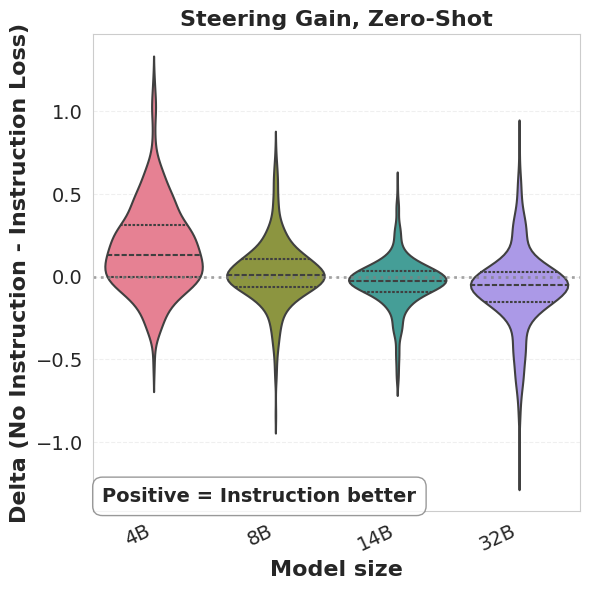

In [6]:
# Violin: delta (log loss improvement) between Indicator + Inst. vs Indicator, by model size.
# Uses a single chosen context length (e.g. ICL=0). Delta = loss(Indicator) − loss(Indicator + Inst.); positive = Indicator + Inst. better.
# Requires results_df with path to PKL files (run PKL loading from plot_results_mortality_csv if needed).

if "results_df" not in globals() or not isinstance(results_df, pd.DataFrame) or results_df.empty:
    raise RuntimeError("Run the PKL loading cell first to create results_df (e.g. from plot_results_mortality_csv).")

_vf2_icl = 0
_vf2_cohort = "ccu"
_vf2_strategy_compare = "Indicator + Inst."
_vf2_strategy_base = "Indicator"
_vf2_zero_shot_strategy = zero_shot_strategy_plot

rf_meta2 = results_df.copy()
if "serialization_strategy" not in rf_meta2.columns and "explicit_missingness" in rf_meta2.columns and "include_cot_prompt" in rf_meta2.columns:
    rf_meta2["serialization_strategy"] = rf_meta2.apply(
        lambda r: strategy_label(r["explicit_missingness"], r["include_cot_prompt"]), axis=1
    )

rf2 = rf_meta2.copy()
rf2["_ck"] = rf2["cohort"].fillna("all").astype(str).str.lower()
if _vf2_cohort is not None:
    rf2 = rf2[rf2["_ck"] == str(_vf2_cohort).strip().lower()]
rf2 = rf2[rf2["icl_num_examples"] == _vf2_icl]
rf2 = rf2[rf2["serialization_strategy"].isin([_vf2_strategy_compare, _vf2_strategy_base])]

# For zero-shot (ICL=0), filter by zero_shot_variant if specified
if _vf2_icl == 0 and _vf2_zero_shot_strategy is not None:
    if "zero_shot_variant" not in rf2.columns:
        # Fallback: infer from path if column doesn't exist
        path_str = rf2["path"].astype(str).str.lower() if "path" in rf2.columns else pd.Series([""] * len(rf2))
        rf2["zero_shot_variant"] = "other"
        rf2.loc[
            path_str.str.contains(r"_icl0_baseline(_|\\.)", regex=True),
            "zero_shot_variant",
        ] = "baseline"
        rf2.loc[
            (~path_str.str.contains(r"_icl0_baseline(_|\\.)", regex=True))
            & path_str.str.contains(r"_icl0(_|\\.)", regex=True),
            "zero_shot_variant",
        ] = "standard"
    rf2 = rf2[rf2["zero_shot_variant"].astype(str).str.lower() == str(_vf2_zero_shot_strategy).strip().lower()]

if rf2.empty:
    raise RuntimeError("No runs for chosen ICL/cohort/strategies. Check _vf2_icl, _vf2_cohort, _vf2_strategy_compare, _vf2_strategy_base, _vf2_zero_shot_strategy.")

from collections import defaultdict
violin_rows2 = []
for model in rf2["model"].unique():
    paths_compare = rf2[(rf2["model"] == model) & (rf2["serialization_strategy"] == _vf2_strategy_compare)]["path"].drop_duplicates().tolist()
    paths_base = rf2[(rf2["model"] == model) & (rf2["serialization_strategy"] == _vf2_strategy_base)]["path"].drop_duplicates().tolist()
    if not paths_compare or not paths_base:
        continue
    preds_compare = defaultdict(list)
    for path in paths_compare:
        data = _load_pred_label_vf(path)
        if data is None:
            continue
        for sid, (p, y) in data.items():
            preds_compare[sid].append((p, y))
    preds_base = defaultdict(list)
    for path in paths_base:
        data = _load_pred_label_vf(path)
        if data is None:
            continue
        for sid, (p, y) in data.items():
            preds_base[sid].append((p, y))
    common = set(preds_compare.keys()) & set(preds_base.keys())
    for sid in common:
        pc = np.mean([x[0] for x in preds_compare[sid]])
        pb = np.mean([x[0] for x in preds_base[sid]])
        y = preds_compare[sid][0][1]
        loss_compare = -(y * np.log(pc) + (1 - y) * np.log(1 - pc))
        loss_base = -(y * np.log(pb) + (1 - y) * np.log(1 - pb))
        delta = loss_base - loss_compare
        violin_rows2.append({
            "model": model,
            "model_size": _model_size_label(model),
            "delta": delta,
        })

violin_df2 = pd.DataFrame(violin_rows2)
if violin_df2.empty:
    raise RuntimeError("No per-subject deltas. Check that both strategies have runs for the chosen ICL/cohort.")
model_order_vf2 = sorted(violin_df2["model"].unique(), key=_model_sort_key)
model_size_order2 = list(dict.fromkeys([_model_size_label(m) for m in model_order_vf2]))
violin_df2["model_size"] = pd.Categorical(violin_df2["model_size"], categories=model_size_order2, ordered=True)

# Create a distinct color palette for each model size
n_sizes2 = len(model_size_order2)
violin_palette2 = sns.color_palette("husl", n_colors=n_sizes2)
violin_color_dict2 = dict(zip(model_size_order2, violin_palette2))

fig, ax = plt.subplots(figsize=(max(6, len(model_size_order2) * 1.2), 6))
sns.violinplot(
    data=violin_df2, x="model_size", y="delta", order=model_size_order2, ax=ax,
    inner="quart",
    palette=violin_palette2,  # Distinct colors for each model size
    linewidth=1.5,  # Thicker violin edges
    width=0.8,  # Width of violins
)
ax.axhline(y=0, color="grey", linestyle="dotted", linewidth=2, alpha=0.7)
ax.set_xlabel("Model size", fontsize=16, fontweight="bold")
ax.set_ylabel("Delta (No Instruction - Instruction Loss)", fontsize=16, fontweight="bold")
ax.set_title("Steering Gain, Zero-Shot", fontsize=16, fontweight="bold")
ax.tick_params(axis="both", labelsize=14)
plt.xticks(rotation=25, ha="right")
ax.grid(True, alpha=0.3, linestyle="--", axis="y")
# Add mean delta as text above each violin
# for i, model_size in enumerate(model_size_order2):
#     mean_delta = violin_df2[violin_df2["model_size"] == model_size]["delta"].mean()
#     ax.text(i, mean_delta + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.05, 
#             f"μ={mean_delta:.3f}", 
#             ha="center", va="bottom", fontsize=12, fontweight="bold",
#             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7, edgecolor="black"))
# Add text annotation in lower left indicating positive is better
ax.text(0.02, 0.02, f"Positive = Instruction better", 
        transform=ax.transAxes, fontsize=14, fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8, edgecolor="gray"))
plt.tight_layout()
save_path = PLOTS_DIR / f"ccu_mortality_steering.pdf"
plt.savefig(save_path, bbox_inches="tight")
plt.show()

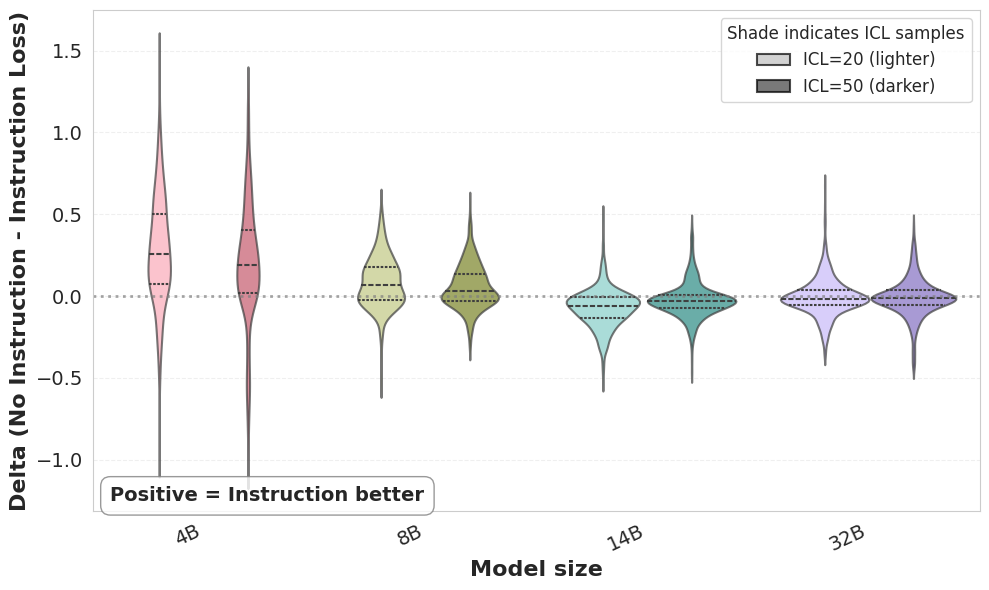

In [7]:
# Violin: delta (log loss improvement) between Indicator + Inst. vs Indicator, by model size.
# Uses a single chosen context length (e.g. ICL=0). Delta = loss(Indicator) − loss(Indicator + Inst.); positive = Indicator + Inst. better.
# Requires results_df with path to PKL files (run PKL loading from plot_results_mortality_csv if needed).

if "results_df" not in globals() or not isinstance(results_df, pd.DataFrame) or results_df.empty:
    raise RuntimeError("Run the PKL loading cell first to create results_df (e.g. from plot_results_mortality_csv).")

_vf2_icl_list = [20, 50]
_vf2_cohort = "ccu"
_vf2_strategy_compare = "Indicator + Inst."
_vf2_icl_strategy = icl_strategy_plot
_vf2_strategy_base = "Indicator"
_vf2_zero_shot_strategy = zero_shot_strategy_plot

rf_meta2 = results_df.copy()
if "serialization_strategy" not in rf_meta2.columns and "explicit_missingness" in rf_meta2.columns and "include_cot_prompt" in rf_meta2.columns:
    rf_meta2["serialization_strategy"] = rf_meta2.apply(
        lambda r: strategy_label(r["explicit_missingness"], r["include_cot_prompt"]), axis=1
    )

# Process data for each ICL value
from collections import defaultdict
all_violin_rows2 = []
for _vf2_icl in _vf2_icl_list:
    rf2 = rf_meta2.copy()
    rf2["_ck"] = rf2["cohort"].fillna("all").astype(str).str.lower()
    if _vf2_cohort is not None:
        rf2 = rf2[rf2["_ck"] == str(_vf2_cohort).strip().lower()]
    rf2 = rf2[rf2["icl_num_examples"] == _vf2_icl]
    rf2 = rf2[rf2["serialization_strategy"].isin([_vf2_strategy_compare, _vf2_strategy_base])]

    # For few-shot (ICL > 0), filter by icl_sampling_strategy if specified
    if _vf2_icl > 0 and _vf2_icl_strategy is not None:
        rf2["icl_sampling_strategy"] = rf2["icl_sampling_strategy"].astype(str).str.lower()
        rf2 = rf2[rf2["icl_sampling_strategy"] == str(_vf2_icl_strategy).strip().lower()]

    # For zero-shot (ICL=0), filter by zero_shot_variant if specified
    if _vf2_icl == 0 and _vf2_zero_shot_strategy is not None:
        if "zero_shot_variant" not in rf2.columns:
            # Fallback: infer from path if column doesn't exist
            path_str = rf2["path"].astype(str).str.lower() if "path" in rf2.columns else pd.Series([""] * len(rf2))
            rf2["zero_shot_variant"] = "other"
            rf2.loc[
                path_str.str.contains(r"_icl0_baseline(_|\\.)", regex=True),
                "zero_shot_variant",
            ] = "baseline"
            rf2.loc[
                (~path_str.str.contains(r"_icl0_baseline(_|\\.)", regex=True))
                & path_str.str.contains(r"_icl0(_|\\.)", regex=True),
                "zero_shot_variant",
            ] = "standard"
        rf2 = rf2[rf2["zero_shot_variant"].astype(str).str.lower() == str(_vf2_zero_shot_strategy).strip().lower()]

    if rf2.empty:
        continue

    violin_rows2 = []
    for model in rf2["model"].unique():
        paths_compare = rf2[(rf2["model"] == model) & (rf2["serialization_strategy"] == _vf2_strategy_compare)]["path"].drop_duplicates().tolist()
        paths_base = rf2[(rf2["model"] == model) & (rf2["serialization_strategy"] == _vf2_strategy_base)]["path"].drop_duplicates().tolist()
        if not paths_compare or not paths_base:
            continue
        preds_compare = defaultdict(list)
        for path in paths_compare:
            data = _load_pred_label_vf(path)
            if data is None:
                continue
            for sid, (p, y) in data.items():
                preds_compare[sid].append((p, y))
        preds_base = defaultdict(list)
        for path in paths_base:
            data = _load_pred_label_vf(path)
            if data is None:
                continue
            for sid, (p, y) in data.items():
                preds_base[sid].append((p, y))
        common = set(preds_compare.keys()) & set(preds_base.keys())
        for sid in common:
            pc = np.mean([x[0] for x in preds_compare[sid]])
            pb = np.mean([x[0] for x in preds_base[sid]])
            y = preds_compare[sid][0][1]
            loss_compare = -(y * np.log(pc) + (1 - y) * np.log(1 - pc))
            loss_base = -(y * np.log(pb) + (1 - y) * np.log(1 - pb))
            delta = loss_base - loss_compare
            violin_rows2.append({
                "model": model,
                "model_size": _model_size_label(model),
                "icl_num_examples": _vf2_icl,
                "delta": delta,
            })
    all_violin_rows2.extend(violin_rows2)

violin_df2 = pd.DataFrame(all_violin_rows2)
if violin_df2.empty:
    raise RuntimeError("No per-subject deltas. Check that both strategies have runs for the chosen ICL/cohort.")
model_order_vf2 = sorted(violin_df2["model"].unique(), key=_model_sort_key)
model_size_order2 = list(dict.fromkeys([_model_size_label(m) for m in model_order_vf2]))
violin_df2["model_size"] = pd.Categorical(violin_df2["model_size"], categories=model_size_order2, ordered=True)

# Create a single plot with grouped violins: two violins per model size (ICL=20 and ICL=50)
violin_df2["icl_num_examples"] = violin_df2["icl_num_examples"].astype(str)

# Create color palette: one color per model size, with lighter/darker shades for ICL values
n_sizes2 = len(model_size_order2)
base_palette = sns.color_palette("husl", n_colors=n_sizes2)

def lighten_color(color, factor=0.4):
    """Lighten a color by mixing with white"""
    import matplotlib.colors as mcolors
    rgb = mcolors.to_rgb(color)
    return tuple(min(1, c + (1 - c) * factor) for c in rgb)

def darken_color(color, factor=0.2):
    """Darken a color by reducing brightness"""
    import matplotlib.colors as mcolors
    rgb = mcolors.to_rgb(color)
    return tuple(c * (1 - factor) for c in rgb)

# Create color mapping: each model size gets a base color, then light/dark versions
model_size_colors = dict(zip(model_size_order2, base_palette))

fig, ax = plt.subplots(figsize=(max(10, len(model_size_order2) * 2), 6))

# Use seaborn violinplot with native inner=quart (shows Q1, median, Q3)
# Explicit hue_order ensures consistent ICL ordering
hue_order = [str(x) for x in _vf2_icl_list]
violin_plot = sns.violinplot(
    data=violin_df2, x="model_size", y="delta", hue="icl_num_examples", 
    order=model_size_order2, hue_order=hue_order, ax=ax,
    inner="quart",  # Seaborn native: dotted lines for quartiles (Q1, median, Q3)
    linewidth=1.5,
    width=0.8,
    split=False,
)

# Customize colors: each model size gets its own color, with light/dark shades for ICL
# Seaborn stores violin bodies as PolyCollection; filter out LineCollection (inner quart lines)
from matplotlib.collections import PolyCollection
violin_collections = [c for c in ax.collections if isinstance(c, PolyCollection)]
col_idx = 0
for i, model_size in enumerate(model_size_order2):
    base_color = model_size_colors[model_size]
    light_color = lighten_color(base_color, factor=0.4)  # Lighter for ICL=20
    dark_color = darken_color(base_color, factor=0.2)     # Darker for ICL=50
    
    for j in range(len(hue_order)):
        if col_idx < len(violin_collections):
            color = light_color if j == 0 else dark_color
            violin_collections[col_idx].set_facecolor(color)
            violin_collections[col_idx].set_alpha(0.7)
            col_idx += 1

# Set x-axis labels and styling
ax.set_xticks(range(len(model_size_order2)))
ax.set_xticklabels(model_size_order2, rotation=25, ha="right")
ax.axhline(y=0, color="grey", linestyle="dotted", linewidth=2, alpha=0.7)
ax.set_xlabel("Model size", fontsize=16, fontweight="bold")
ax.set_ylabel("Delta (No Instruction - Instruction Loss)", fontsize=16, fontweight="bold")
ax.tick_params(axis="both", labelsize=14)
ax.grid(True, alpha=0.3, linestyle="--", axis="y")

# Add median delta as text above each violin (matches quart lines)
for i, model_size in enumerate(model_size_order2):
    for j, icl_val in enumerate(_vf2_icl_list):
        sub_df = violin_df2[(violin_df2["model_size"] == model_size) & 
                            (violin_df2["icl_num_examples"] == str(icl_val))]
        if sub_df.empty:
            continue
        median_delta = sub_df["delta"].median()
        # Position: offset by -0.2 for ICL=20, +0.2 for ICL=50 (relative to center)
        x_pos = i + (-0.2 if j == 0 else 0.2)
        y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
        # ax.text(x_pos, median_delta + y_range * 0.05, 
        #         f"median={median_delta:.3f}", 
        #         ha="center", va="bottom", fontsize=11, fontweight="bold",
        #         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7, edgecolor="black"))

# Create custom legend: show light and dark shades using a sample color
from matplotlib.patches import Patch
sample_color = (0.5, 0.5, 0.5)
legend_elements = [
    Patch(facecolor=lighten_color(sample_color, factor=0.5), alpha=0.7, edgecolor='black', linewidth=1.5, label="ICL=20 (lighter)"),
    Patch(facecolor=darken_color(sample_color, factor=0.5), alpha=0.7, edgecolor='black', linewidth=1.5, label="ICL=50 (darker)")
]
ax.legend(handles=legend_elements, fontsize=12, loc="upper right", title="Shade indicates ICL samples", title_fontsize=12)

# Add text annotation in lower left indicating positive is better
ax.text(0.02, 0.02, f"Positive = Instruction better", 
        transform=ax.transAxes, fontsize=14, fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8, edgecolor="gray"))

plt.tight_layout()
save_path = PLOTS_DIR / f"ccu_mortality_icl_steering_interaction.pdf"
plt.savefig(save_path, bbox_inches="tight")
plt.show()

In [8]:
# # Violin: delta (few-shot - zero-shot loss) by context length, for Indicator variant.
# # X-axis: context length (ICL=20, 50), Y-axis: delta vs zero-shot, Hue: ICL sampling strategy (balanced vs stratified).
# # Requires results_df with path to PKL files (run PKL loading from plot_results_mortality_csv if needed).

# if "results_df" not in globals() or not isinstance(results_df, pd.DataFrame) or results_df.empty:
#     raise RuntimeError("Run the PKL loading cell first to create results_df (e.g. from plot_results_mortality_csv).")

# _vf3_icl_list = [20, 50]
# _vf3_cohort = "ccu"
# _vf3_strategy = "Indicator"  # Only Indicator variant
# _vf3_icl_strategies = ["balanced", "stratified"]
# _vf3_zero_shot_strategy = "Standard"

# rf_meta3 = results_df.copy()
# if "serialization_strategy" not in rf_meta3.columns and "explicit_missingness" in rf_meta3.columns and "include_cot_prompt" in rf_meta3.columns:
#     rf_meta3["serialization_strategy"] = rf_meta3.apply(
#         lambda r: strategy_label(r["explicit_missingness"], r["include_cot_prompt"]), axis=1
#     )

# # Process data: compute delta = loss(few-shot) - loss(zero-shot) for each subject
# from collections import defaultdict
# all_violin_rows3 = []

# # Get zero-shot runs
# rf_zero = rf_meta3.copy()
# rf_zero["_ck"] = rf_zero["cohort"].fillna("all").astype(str).str.lower()
# if _vf3_cohort is not None:
#     rf_zero = rf_zero[rf_zero["_ck"] == str(_vf3_cohort).strip().lower()]
# rf_zero = rf_zero[rf_zero["icl_num_examples"] == 0]
# rf_zero = rf_zero[rf_zero["serialization_strategy"] == _vf3_strategy]

# # Filter zero-shot by variant if specified
# if _vf3_zero_shot_strategy is not None:
#     if "zero_shot_variant" not in rf_zero.columns:
#         path_str = rf_zero["path"].astype(str).str.lower() if "path" in rf_zero.columns else pd.Series([""] * len(rf_zero))
#         rf_zero["zero_shot_variant"] = "other"
#         rf_zero.loc[
#             path_str.str.contains(r"_icl0_baseline(_|\\.)", regex=True),
#             "zero_shot_variant",
#         ] = "baseline"
#         rf_zero.loc[
#             (~path_str.str.contains(r"_icl0_baseline(_|\\.)", regex=True))
#             & path_str.str.contains(r"_icl0(_|\\.)", regex=True),
#             "zero_shot_variant",
#         ] = "standard"
#     rf_zero = rf_zero[rf_zero["zero_shot_variant"].astype(str).str.lower() == str(_vf3_zero_shot_strategy).strip().lower()]

# # Process each ICL value
# for _vf3_icl in _vf3_icl_list:
#     rf_few = rf_meta3.copy()
#     rf_few["_ck"] = rf_few["cohort"].fillna("all").astype(str).str.lower()
#     if _vf3_cohort is not None:
#         rf_few = rf_few[rf_few["_ck"] == str(_vf3_cohort).strip().lower()]
#     rf_few = rf_few[rf_few["icl_num_examples"] == _vf3_icl]
#     rf_few = rf_few[rf_few["serialization_strategy"] == _vf3_strategy]
#     rf_few["icl_sampling_strategy"] = rf_few["icl_sampling_strategy"].astype(str).str.lower()
#     rf_few = rf_few[rf_few["icl_sampling_strategy"].isin([s.lower() for s in _vf3_icl_strategies])]

#     if rf_zero.empty or rf_few.empty:
#         continue

#     # For each model, compute per-subject deltas
#     for model in rf_few["model"].unique():
#         paths_zero = rf_zero[rf_zero["model"] == model]["path"].drop_duplicates().tolist()
#         if not paths_zero:
#             continue
        
#         for icl_strategy in _vf3_icl_strategies:
#             paths_few = rf_few[(rf_few["model"] == model) & 
#                                (rf_few["icl_sampling_strategy"] == icl_strategy.lower())]["path"].drop_duplicates().tolist()
#             if not paths_few:
#                 continue
            
#             # Load and average predictions for zero-shot
#             preds_zero = defaultdict(list)
#             for path in paths_zero:
#                 data = _load_pred_label_vf(path)
#                 if data is None:
#                     continue
#                 for sid, (p, y) in data.items():
#                     preds_zero[sid].append((p, y))
            
#             # Load and average predictions for few-shot
#             preds_few = defaultdict(list)
#             for path in paths_few:
#                 data = _load_pred_label_vf(path)
#                 if data is None:
#                     continue
#                 for sid, (p, y) in data.items():
#                     preds_few[sid].append((p, y))
            
#             # Compute delta = loss(few) - loss(zero) for common subjects
#             common = set(preds_zero.keys()) & set(preds_few.keys())
#             for sid in common:
#                 p_zero = np.mean([x[0] for x in preds_zero[sid]])
#                 p_few = np.mean([x[0] for x in preds_few[sid]])
#                 y = preds_zero[sid][0][1]
#                 loss_zero = -(y * np.log(p_zero) + (1 - y) * np.log(1 - p_zero))
#                 loss_few = -(y * np.log(p_few) + (1 - y) * np.log(1 - p_few))
#                 delta = loss_zero - loss_few  # Positive = few-shot better than zero-shot
#                 all_violin_rows3.append({
#                     "model": model,
#                     "model_size": _model_size_label(model),
#                     "icl_num_examples": _vf3_icl,
#                     "icl_sampling_strategy": icl_strategy,
#                     "delta": delta,
#                 })

# violin_df3 = pd.DataFrame(all_violin_rows3)
# if violin_df3.empty:
#     raise RuntimeError("No per-subject deltas. Check that zero-shot and few-shot runs exist for the chosen variant/cohort.")
# violin_df3["icl_num_examples"] = violin_df3["icl_num_examples"].astype(int)
# violin_df3["icl_sampling_strategy"] = violin_df3["icl_sampling_strategy"].astype(str).str.capitalize()

# # Create nested x-axis: model_size groups with ICL nested within
# model_order_vf3 = sorted(violin_df3["model"].unique(), key=_model_sort_key)
# model_size_order3 = list(dict.fromkeys([_model_size_label(m) for m in model_order_vf3]))
# violin_df3["model_size"] = pd.Categorical(violin_df3["model_size"], categories=model_size_order3, ordered=True)

# # Create combined x-axis variable: (model_size, icl_num_examples)
# violin_df3["x_group"] = violin_df3.apply(
#     lambda r: f"{r['model_size']}_{r['icl_num_examples']}", axis=1
# )
# # Order: for each model_size, then each ICL value
# x_order = []
# for model_size in model_size_order3:
#     for icl_val in _vf3_icl_list:
#         x_order.append(f"{model_size}_{icl_val}")
# violin_df3["x_group"] = pd.Categorical(violin_df3["x_group"], categories=x_order, ordered=True)

# # Create color palette: one color per model size, with lighter/darker shades for ICL values
# n_sizes3 = len(model_size_order3)
# base_palette3 = sns.color_palette("husl", n_colors=n_sizes3)
# model_size_colors3 = dict(zip(model_size_order3, base_palette3))

# def lighten_color(color, factor=0.4):
#     """Lighten a color by mixing with white"""
#     import matplotlib.colors as mcolors
#     rgb = mcolors.to_rgb(color)
#     return tuple(min(1, c + (1 - c) * factor) for c in rgb)

# def darken_color(color, factor=0.2):
#     """Darken a color by reducing brightness"""
#     import matplotlib.colors as mcolors
#     rgb = mcolors.to_rgb(color)
#     return tuple(c * (1 - factor) for c in rgb)

# fig, ax = plt.subplots(figsize=(max(12, len(model_size_order3) * len(_vf3_icl_list) * 1.5), 6))

# # Use seaborn violinplot with native inner=quart
# hue_order3 = [s.capitalize() for s in _vf3_icl_strategies]
# violin_plot3 = sns.violinplot(
#     data=violin_df3, x="x_group", y="delta", hue="icl_sampling_strategy", 
#     order=x_order, hue_order=hue_order3, ax=ax,
#     inner="quart",  # Seaborn native: dotted lines for quartiles (Q1, median, Q3)
#     linewidth=1.5,
#     width=0.8,
#     split=False,
# )

# # Customize colors: each model size gets its own color, with light/dark shades for ICL values
# from matplotlib.collections import PolyCollection
# violin_collections3 = [c for c in ax.collections if isinstance(c, PolyCollection)]
# col_idx3 = 0
# for i, model_size in enumerate(model_size_order3):
#     base_color = model_size_colors3[model_size]
#     light_color = lighten_color(base_color, factor=0.4)  # Lighter for ICL=20
#     dark_color = darken_color(base_color, factor=0.2)     # Darker for ICL=50
    
#     for j, icl_val in enumerate(_vf3_icl_list):
#         # For each (model_size, ICL) combination, we have 2 violins (balanced, stratified)
#         for k in range(len(hue_order3)):
#             if col_idx3 < len(violin_collections3):
#                 # Use ICL shade: lighter for ICL=20, darker for ICL=50
#                 color = light_color if j == 0 else dark_color
#                 violin_collections3[col_idx3].set_facecolor(color)
#                 violin_collections3[col_idx3].set_alpha(0.7)
#                 col_idx3 += 1

# # Set x-axis labels: nested structure
# ax.axhline(y=0, color="grey", linestyle="dotted", linewidth=2, alpha=0.7)
# ax.set_ylabel("Delta (zero-shot − few-shot loss)", fontsize=16, fontweight="bold")
# ax.tick_params(axis="both", labelsize=14)
# ax.grid(True, alpha=0.3, linestyle="--", axis="y")

# # Create nested x-axis labels
# x_tick_positions = []
# x_tick_labels_bottom = []  # ICL labels for bottom axis
# x_tick_positions_top = []  # Model size positions for top axis
# x_tick_labels_top = []     # Model size labels for top axis

# for i, model_size in enumerate(model_size_order3):
#     for j, icl_val in enumerate(_vf3_icl_list):
#         pos = i * len(_vf3_icl_list) + j
#         x_tick_positions.append(pos)
#         x_tick_labels_bottom.append(f"{icl_val}")
    
#     # Add separator line between model size groups
#     if i < len(model_size_order3) - 1:
#         sep_pos = (i + 1) * len(_vf3_icl_list) - 0.5
#         ax.axvline(x=sep_pos, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
#     # Model size label position (center of group)
#     center_pos = i * len(_vf3_icl_list) + (len(_vf3_icl_list) - 1) / 2
#     x_tick_positions_top.append(center_pos)
#     x_tick_labels_top.append(model_size)

# # Set bottom x-axis: ICL labels
# ax.set_xticks(x_tick_positions)
# ax.set_xticklabels(x_tick_labels_bottom, rotation=0, ha="center")
# ax.set_xlabel("Context samples", fontsize=16, fontweight="bold")

# # Create top x-axis: Model size labels
# ax_top = ax.secondary_xaxis('top')
# ax_top.set_xticks(x_tick_positions_top)
# ax_top.set_xticklabels(x_tick_labels_top, rotation=0, ha="center", fontsize=14, fontweight="bold")
# ax_top.set_xlabel("Model size", fontsize=16, fontweight="bold")
# ax_top.tick_params(axis='x', labelsize=14)

# # Create custom legend: show ICL sampling strategies
# from matplotlib.patches import Patch
# legend_elements3 = [
#     Patch(facecolor='lightgray', alpha=0.7, edgecolor='black', linewidth=1.5, label=f"{hue_order3[0]}"),
#     Patch(facecolor='darkgray', alpha=0.7, edgecolor='black', linewidth=1.5, label=f"{hue_order3[1]}")
# ]
# ax.legend(handles=legend_elements3, fontsize=12, loc="upper right", title="ICL sampling strategy", title_fontsize=12)

# # Add text annotation in lower left
# ax.text(0.02, 0.02, f"Positive = few-shot better than zero-shot", 
#         transform=ax.transAxes, fontsize=14, fontweight="bold",
#         bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8, edgecolor="gray"))

# plt.tight_layout()
# plt.show()

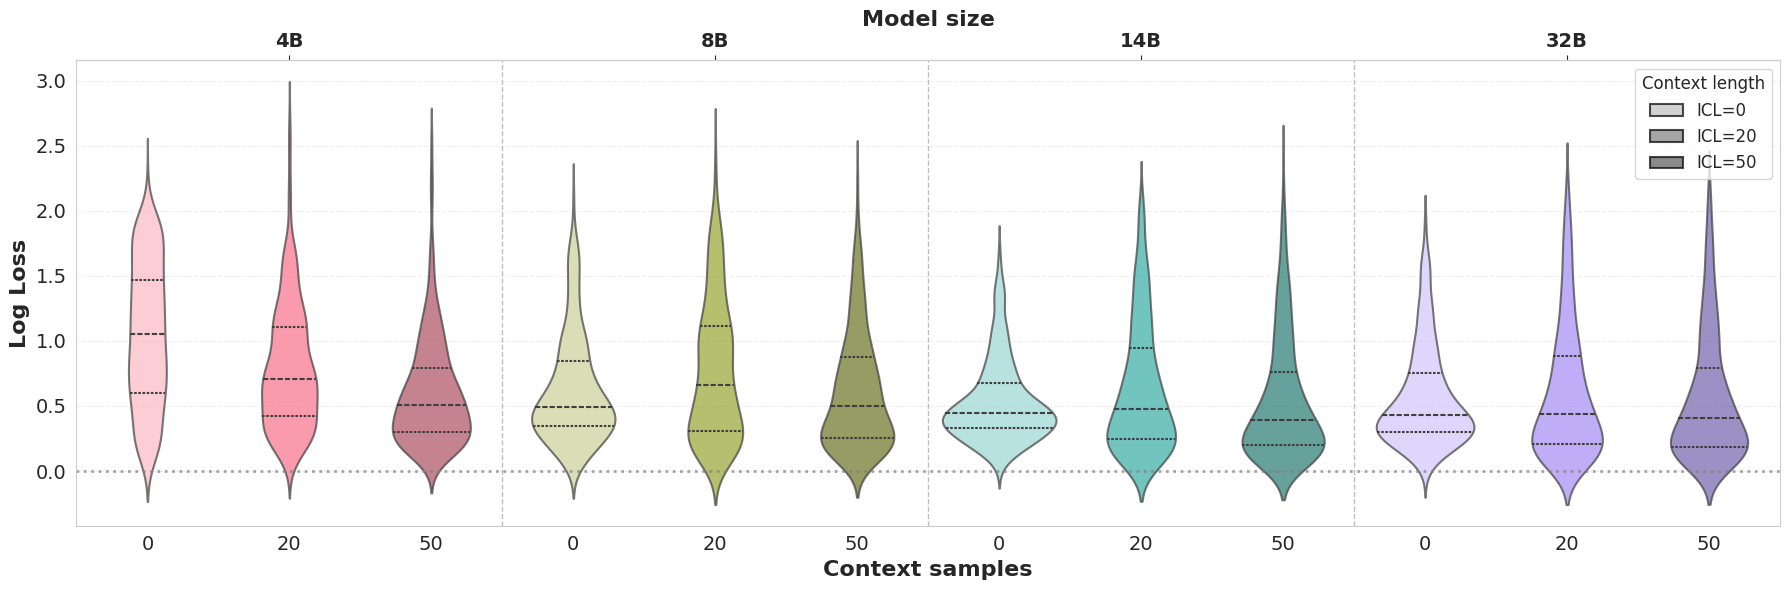

In [9]:
# Violin: Loss (not delta) by model size, for Indicator variant with Stratified sampling.
# X-axis: model size, Y-axis: loss, Hue: context length (ICL=0, 20, 50).
# Requires results_df with path to PKL files (run PKL loading from plot_results_mortality_csv if needed).

if "results_df" not in globals() or not isinstance(results_df, pd.DataFrame) or results_df.empty:
    raise RuntimeError("Run the PKL loading cell first to create results_df (e.g. from plot_results_mortality_csv).")

_vf4_icl_list = [0, 20, 50]
_vf4_cohort = "ccu"
_vf4_strategy = "Indicator"
_vf4_icl_strategy = icl_strategy_plot
_vf4_zero_shot_strategy = zero_shot_strategy_plot

rf_meta4 = results_df.copy()
if "serialization_strategy" not in rf_meta4.columns and "explicit_missingness" in rf_meta4.columns and "include_cot_prompt" in rf_meta4.columns:
    rf_meta4["serialization_strategy"] = rf_meta4.apply(
        lambda r: strategy_label(r["explicit_missingness"], r["include_cot_prompt"]), axis=1
    )

# Process data: compute loss for each subject (averaged predictions over seeds)
from collections import defaultdict
all_violin_rows4 = []

for _vf4_icl in _vf4_icl_list:
    rf4 = rf_meta4.copy()
    rf4["_ck"] = rf4["cohort"].fillna("all").astype(str).str.lower()
    if _vf4_cohort is not None:
        rf4 = rf4[rf4["_ck"] == str(_vf4_cohort).strip().lower()]
    rf4 = rf4[rf4["icl_num_examples"] == _vf4_icl]
    rf4 = rf4[rf4["serialization_strategy"] == _vf4_strategy]
    
    # For few-shot (ICL > 0), filter by icl_sampling_strategy
    if _vf4_icl > 0:
        rf4["icl_sampling_strategy"] = rf4["icl_sampling_strategy"].astype(str).str.lower()
        rf4 = rf4[rf4["icl_sampling_strategy"] == str(_vf4_icl_strategy).strip().lower()]
    
    # For zero-shot (ICL=0), filter by zero_shot_variant if specified
    if _vf4_icl == 0 and _vf4_zero_shot_strategy is not None:
        if "zero_shot_variant" not in rf4.columns:
            path_str = rf4["path"].astype(str).str.lower() if "path" in rf4.columns else pd.Series([""] * len(rf4))
            rf4["zero_shot_variant"] = "other"
            rf4.loc[
                path_str.str.contains(r"_icl0_baseline(_|\\.)", regex=True),
                "zero_shot_variant",
            ] = "baseline"
            rf4.loc[
                (~path_str.str.contains(r"_icl0_baseline(_|\\.)", regex=True))
                & path_str.str.contains(r"_icl0(_|\\.)", regex=True),
                "zero_shot_variant",
            ] = "standard"
        rf4 = rf4[rf4["zero_shot_variant"].astype(str).str.lower() == str(_vf4_zero_shot_strategy).strip().lower()]
    
    if rf4.empty:
        continue
    
    # For each model, compute per-subject losses
    for model in rf4["model"].unique():
        paths = rf4[rf4["model"] == model]["path"].drop_duplicates().tolist()
        if not paths:
            continue
        
        # Load and average predictions across seeds
        preds = defaultdict(list)
        for path in paths:
            data = _load_pred_label_vf(path)
            if data is None:
                continue
            for sid, (p, y) in data.items():
                preds[sid].append((p, y))
        
        # Compute loss from averaged predictions
        for sid in preds.keys():
            p_avg = np.mean([x[0] for x in preds[sid]])
            y = preds[sid][0][1]
            loss = -(y * np.log(p_avg) + (1 - y) * np.log(1 - p_avg))
            all_violin_rows4.append({
                "model": model,
                "model_size": _model_size_label(model),
                "icl_num_examples": _vf4_icl,
                "loss": loss,
            })

violin_df4 = pd.DataFrame(all_violin_rows4)
if violin_df4.empty:
    raise RuntimeError("No loss data. Check that runs exist for the chosen variant/cohort/ICL values.")
model_order_vf4 = sorted(violin_df4["model"].unique(), key=_model_sort_key)
model_size_order4 = list(dict.fromkeys([_model_size_label(m) for m in model_order_vf4]))
violin_df4["model_size"] = pd.Categorical(violin_df4["model_size"], categories=model_size_order4, ordered=True)
violin_df4["icl_num_examples"] = violin_df4["icl_num_examples"].astype(int)

# Create nested x-axis: model_size groups with ICL nested within
violin_df4["x_group"] = violin_df4.apply(
    lambda r: f"{r['model_size']}_{r['icl_num_examples']}", axis=1
)
# Order: for each model_size, then each ICL value
x_order4 = []
for model_size in model_size_order4:
    for icl_val in _vf4_icl_list:
        x_order4.append(f"{model_size}_{icl_val}")
violin_df4["x_group"] = pd.Categorical(violin_df4["x_group"], categories=x_order4, ordered=True)

# Create color palette: one color per model size, with different shades for ICL values
n_sizes4 = len(model_size_order4)
base_palette4 = sns.color_palette("husl", n_colors=n_sizes4)
model_size_colors4 = dict(zip(model_size_order4, base_palette4))

def lighten_color(color, factor=0.4):
    """Lighten a color by mixing with white"""
    import matplotlib.colors as mcolors
    rgb = mcolors.to_rgb(color)
    return tuple(min(1, c + (1 - c) * factor) for c in rgb)

def darken_color(color, factor=0.2):
    """Darken a color by reducing brightness"""
    import matplotlib.colors as mcolors
    rgb = mcolors.to_rgb(color)
    return tuple(c * (1 - factor) for c in rgb)

fig, ax = plt.subplots(figsize=(max(12, len(model_size_order4) * len(_vf4_icl_list) * 1.5), 6))

# Use seaborn violinplot with native inner=quart (no hue since ICL is in x_group)
violin_plot4 = sns.violinplot(
    data=violin_df4, x="x_group", y="loss", 
    order=x_order4, ax=ax,
    inner="quart",  # Seaborn native: dotted lines for quartiles (Q1, median, Q3)
    linewidth=1.5,
    width=0.8,
)

# Customize colors: each model size gets its own color, with different shades for ICL values
from matplotlib.collections import PolyCollection
violin_collections4 = [c for c in ax.collections if isinstance(c, PolyCollection)]
col_idx4 = 0
for i, model_size in enumerate(model_size_order4):
    base_color = model_size_colors4[model_size]
    # Create shades: lightest for ICL=0, medium for ICL=20, darkest for ICL=50
    colors_shades = [
        lighten_color(base_color, factor=0.5),  # Lightest for ICL=0
        base_color,                              # Base for ICL=20
        darken_color(base_color, factor=0.3),   # Darkest for ICL=50
    ]
    
    for j, icl_val in enumerate(_vf4_icl_list):
        if col_idx4 < len(violin_collections4):
            violin_collections4[col_idx4].set_facecolor(colors_shades[j])
            violin_collections4[col_idx4].set_alpha(0.7)
            col_idx4 += 1

# Set x-axis labels: nested structure
ax.axhline(y=0, color="grey", linestyle="dotted", linewidth=2, alpha=0.7)
ax.set_ylabel("Log Loss", fontsize=16, fontweight="bold")
ax.tick_params(axis="both", labelsize=14)
ax.grid(True, alpha=0.3, linestyle="--", axis="y")

# Create nested x-axis labels
x_tick_positions4 = []
x_tick_labels_bottom4 = []  # ICL labels for bottom axis
x_tick_positions_top4 = []  # Model size positions for top axis
x_tick_labels_top4 = []     # Model size labels for top axis

for i, model_size in enumerate(model_size_order4):
    for j, icl_val in enumerate(_vf4_icl_list):
        pos = i * len(_vf4_icl_list) + j
        x_tick_positions4.append(pos)
        x_tick_labels_bottom4.append(f"{icl_val}")
    
    # Add separator line between model size groups
    if i < len(model_size_order4) - 1:
        sep_pos = (i + 1) * len(_vf4_icl_list) - 0.5
        ax.axvline(x=sep_pos, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    # Model size label position (center of group)
    center_pos = i * len(_vf4_icl_list) + (len(_vf4_icl_list) - 1) / 2
    x_tick_positions_top4.append(center_pos)
    x_tick_labels_top4.append(model_size)

# Set bottom x-axis: ICL labels
ax.set_xticks(x_tick_positions4)
ax.set_xticklabels(x_tick_labels_bottom4, rotation=0, ha="center")
ax.set_xlabel("Context samples", fontsize=16, fontweight="bold")

# Create top x-axis: Model size labels
ax_top4 = ax.secondary_xaxis('top')
ax_top4.set_xticks(x_tick_positions_top4)
ax_top4.set_xticklabels(x_tick_labels_top4, rotation=0, ha="center", fontsize=14, fontweight="bold")
ax_top4.set_xlabel("Model size", fontsize=16, fontweight="bold")
ax_top4.tick_params(axis='x', labelsize=14)

# Create custom legend: show ICL values
from matplotlib.patches import Patch
legend_elements4 = [
    Patch(facecolor=lighten_color((0.5, 0.5, 0.5), factor=0.5), alpha=0.7, edgecolor='black', linewidth=1.5, label="ICL=0"),
    Patch(facecolor=(0.5, 0.5, 0.5), alpha=0.7, edgecolor='black', linewidth=1.5, label="ICL=20"),
    Patch(facecolor=darken_color((0.5, 0.5, 0.5), factor=0.3), alpha=0.7, edgecolor='black', linewidth=1.5, label="ICL=50")
]
ax.legend(handles=legend_elements4, fontsize=12, loc="upper right", title="Context length", title_fontsize=12)

plt.tight_layout()
save_path = PLOTS_DIR / f"ccu_mortality_icl_loss_all.pdf"
plt.savefig(save_path, bbox_inches="tight")
plt.show()

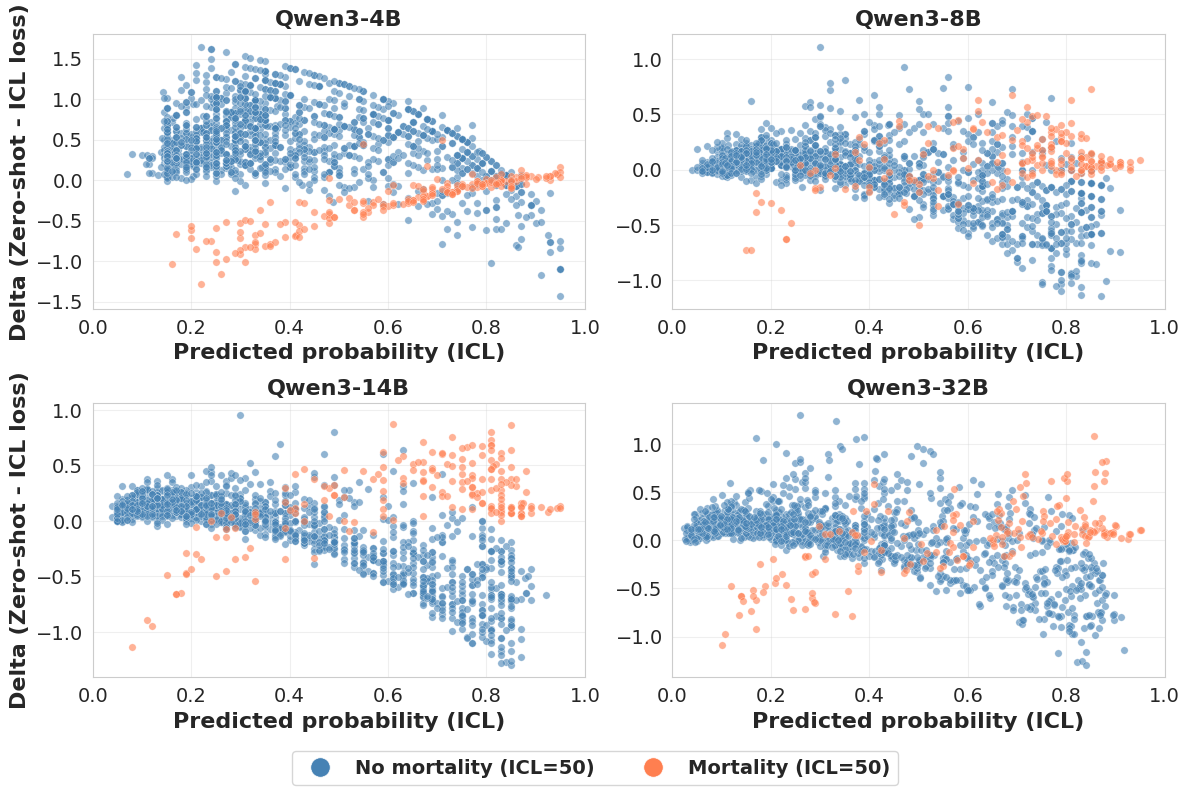

In [10]:
# Scatter: delta (y) vs predicted probability (x), colored by ground-truth label
# Reuses box_df from the "Delta by outcome" boxplot cell when available (same cohort/filters; includes averaged pred_few when that cell used averaged predictions).

if "results_df" not in globals() or not isinstance(results_df, pd.DataFrame) or results_df.empty:
    raise RuntimeError("Run the PKL loading cell first to create results_df.")

_s_cohort = "ccu"
_s_icl_sampling = icl_strategy_plot
_s_zero_shot_variant = zero_shot_strategy_plot
_s_serialization_strategy = None
_s_icl_overlay = [50]

def _model_sort_key_s(m):
    s = str(m).lower()
    size_match = re.search(r"(\d+(?:\.\d+)?)\s*([bm])\b", s)
    size_b = float(size_match.group(1)) if size_match and size_match.group(2) == "b" else (float(size_match.group(1)) / 1000.0 if size_match else float("inf"))
    return (s.split("/")[0] if "/" in s else s.split("-")[0], size_b, s)

if "box_df" in globals() and isinstance(box_df, pd.DataFrame) and not box_df.empty and "pred_few" in box_df.columns:
    scatter_df = box_df[["model", "icl_num_examples", "outcome", "delta", "pred_few"]].copy()
    model_order_s = sorted(scatter_df["model"].unique(), key=_model_sort_key_s)
    _scatter_reused_box = True
else:
    _scatter_reused_box = False
    eps = 1e-6
    def _per_subject_loss_label_pred(path):
        d = safe_load_pickle(path)
        if not isinstance(d, dict):
            return None
        out = {}
        for sid, item in d.items():
            if not isinstance(item, dict) or item.get("label") is None:
                continue
            y = int(bool(item.get("label")))
            sp = item.get("prediction_samples")
            if isinstance(sp, list):
                probs = [float(p) for p in sp if is_prob(p)]
            else:
                probs = []
            p = float(np.mean(probs)) if probs else item.get("prediction")
            if not is_prob(p):
                continue
            p = np.clip(float(p), eps, 1 - eps)
            out[sid] = {"loss": -(y * np.log(p) + (1 - y) * np.log(1 - p)), "label": y, "pred": float(p)}
        return out

    qwen_s = results_df[results_df["model"].astype(str).str.contains("Qwen", case=False, na=False)].copy()
    qwen_s["_ck"] = qwen_s["cohort"].fillna("all").astype(str).str.lower()
    if _s_cohort is not None:
        qwen_s = qwen_s[qwen_s["_ck"] == str(_s_cohort).strip().lower()]
    if _s_serialization_strategy is not None:
        qwen_s = qwen_s[qwen_s["serialization_strategy"] == _s_serialization_strategy]
    zero_s = qwen_s[qwen_s["icl_num_examples"] == 0].copy()
    if "zero_shot_variant" in zero_s.columns:
        zero_s = zero_s[zero_s["zero_shot_variant"].astype(str).str.lower() == str(_s_zero_shot_variant).strip().lower()]
    zero_s = zero_s[["model", "serialization_strategy", "_ck", "seed", "path"]].rename(columns={"path": "path_zero"})
    zero_s = zero_s.drop_duplicates(subset=["model", "serialization_strategy", "_ck", "seed"])
    few_s = qwen_s[qwen_s["icl_num_examples"] > 0].copy()
    allowed_s = [s.strip().lower() for s in (_s_icl_sampling if isinstance(_s_icl_sampling, (list, tuple)) else [_s_icl_sampling])]
    few_s["_s"] = few_s["icl_sampling_strategy"].astype(str).str.lower()
    few_s = few_s[few_s["_s"].isin(allowed_s)].drop(columns=["_s"])
    few_s = few_s[["model", "serialization_strategy", "_ck", "seed", "icl_num_examples", "path"]].rename(columns={"path": "path_few"})
    run_pairs_s = few_s.merge(zero_s, on=["model", "serialization_strategy", "_ck", "seed"], how="inner")
    run_pairs_s = run_pairs_s[run_pairs_s["icl_num_examples"].isin(_s_icl_overlay)]
    if run_pairs_s.empty:
        raise RuntimeError("No run pairs. Check _s_cohort, _s_icl_sampling, _s_zero_shot_variant.")

    scatter_rows = []
    for _, row in run_pairs_s.iterrows():
        l0 = _per_subject_loss_label_pred(row["path_zero"])
        lf = _per_subject_loss_label_pred(row["path_few"])
        if l0 is None or lf is None:
            continue
        for sid in set(l0.keys()) & set(lf.keys()):
            delta = l0[sid]["loss"] - lf[sid]["loss"]  # Zero-shot − few-shot; positive = few-shot better
            label = l0[sid]["label"]
            pred_few = lf[sid]["pred"]
            scatter_rows.append({
                "model": row["model"],
                "icl_num_examples": int(row["icl_num_examples"]),
                "outcome": label,
                "delta": delta,
                "pred_few": pred_few,
            })
    scatter_df = pd.DataFrame(scatter_rows)
    if scatter_df.empty:
        raise RuntimeError("No scatter data.")
    scatter_df["outcome"] = scatter_df["outcome"].map({0: "No mortality", 1: "Mortality"})
    model_order_s = sorted(scatter_df["model"].unique(), key=_model_sort_key_s)

n_m = len(model_order_s)
n_cols = 2
n_rows = (n_m + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
if n_m == 1:
    axes = np.array([axes])
axes = axes.flat
outcome_colors = {"No mortality": "steelblue", "Mortality": "coral"}
icl_markers = {20: "^", 50: "o"}
for idx, model in enumerate(model_order_s):
    ax = axes[idx]
    sub = scatter_df[scatter_df["model"] == model]
    for icl in _s_icl_overlay:
        s = sub[sub["icl_num_examples"] == icl]
        if s.empty:
            continue
        for outcome_name in ["No mortality", "Mortality"]:
            mask = s["outcome"] == outcome_name
            if not mask.any():
                continue
            ax.scatter(
                s.loc[mask, "pred_few"], s.loc[mask, "delta"],
                c=outcome_colors[outcome_name], label=f"{outcome_name} (ICL={icl})",
                alpha=0.6, marker=icl_markers.get(icl, "o"), s=28, edgecolors="white", linewidths=0.3,
            )
    ax.set_xlabel("Predicted probability (ICL)", fontsize=16, fontweight="bold")
    if idx % n_cols == 0:
        ax.set_ylabel("Delta (Zero-shot - ICL loss)", fontsize=16, fontweight="bold")
    else:
        ax.set_ylabel("")
    ax.set_title(str(model), fontsize=16, fontweight="bold")
    ax.tick_params(axis="both", labelsize=14)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 1)
for j in range(len(model_order_s), len(axes)):
    axes[j].set_visible(False)

# Single legend at the bottom of the figure
from matplotlib.lines import Line2D
legend_handles = []
for outcome_name in ["No mortality", "Mortality"]:
    for icl in _s_icl_overlay:
        legend_handles.append(Line2D(
            [0], [0], marker=icl_markers.get(icl, "o"), color='w', markerfacecolor=outcome_colors[outcome_name],
            markersize=14, markeredgecolor='white', markeredgewidth=0.5, label=f"{outcome_name} (ICL={icl})"
        ))
fig.legend(handles=legend_handles, loc='lower center', ncol=len(_s_icl_overlay) * 2, prop=dict(size=14, weight='bold'), frameon=True)
plt.tight_layout(rect=[0, 0.06, 1, 1])  # Leave space at bottom for legend
save_path = PLOTS_DIR / f"ccu_mortality_icl_scatter_delta.pdf"
plt.savefig(save_path, bbox_inches="tight")
plt.show()

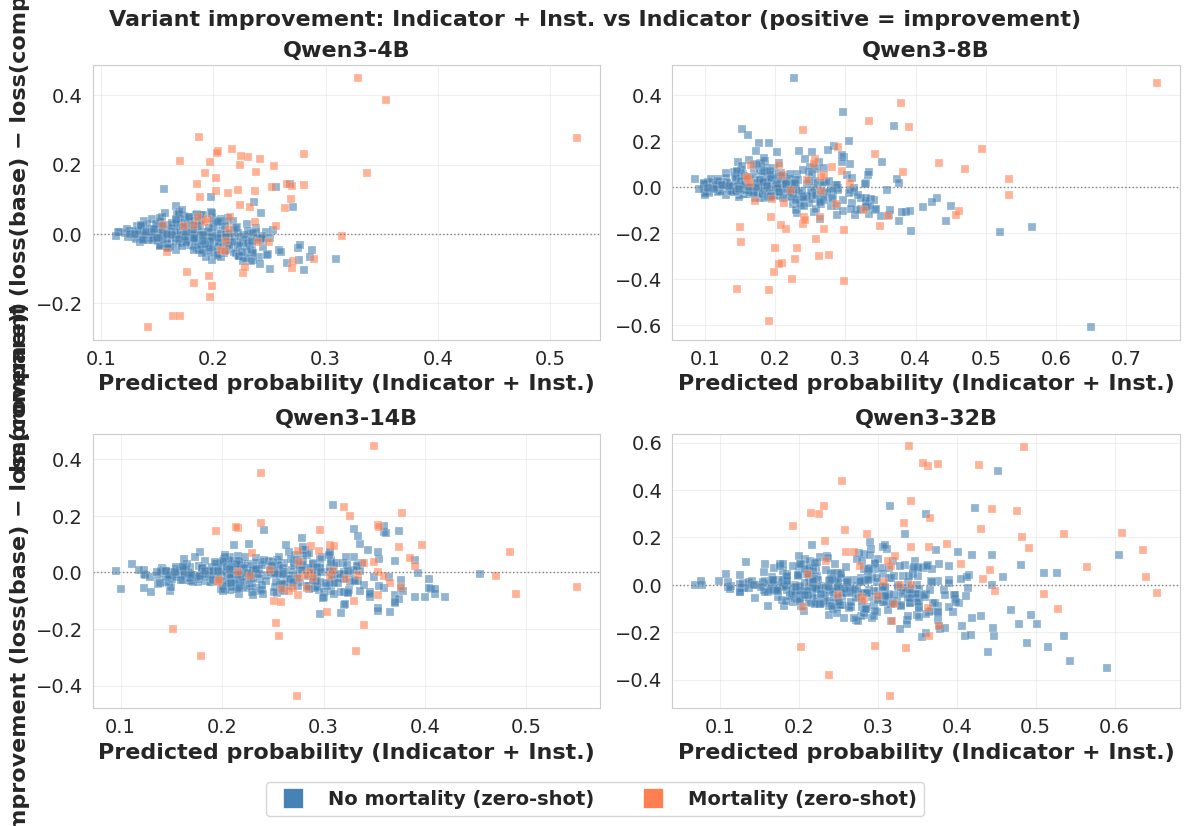

In [11]:
# Scatter: delta (variant improvement) vs predicted probability.
# Few-shot: delta = loss(base) − loss(compare) at ICL=20/50; zero-shot: same delta at ICL=0 (delta across variants).

if "results_df" not in globals() or not isinstance(results_df, pd.DataFrame) or results_df.empty:
    raise RuntimeError("Run the PKL loading cell first to create results_df.")

_sv_cohort = "ccu"
_sv_icl_sampling = icl_strategy_plot
_sv_icl_overlay = [20]   # few-shot ICL values to compare (e.g. [20] or [20, 50])
_sv_variant_compare = "Indicator + Inst."  # variant for x-axis pred and denominator of delta
_sv_variant_base = "Indicator"             # delta = loss(base) − loss(compare), positive = compare better
_sv_include_few_shot = False               # if True, overlay few-shot variant improvement; if False, only zero-shot
_sv_include_zero_shot_variant = True       # if True, plot delta across variants at zero-shot (ICL=0)
_sv_zero_shot_variant = "baseline"         # filter zero-shot runs by this variant (e.g. baseline / standard)

def _model_sort_key_sv(m):
    s = str(m).lower()
    size_match = re.search(r"(\d+(?:\.\d+)?)\s*([bm])\b", s)
    size_b = float(size_match.group(1)) if size_match and size_match.group(2) == "b" else (float(size_match.group(1)) / 1000.0 if size_match else float("inf"))
    return (s.split("/")[0] if "/" in s else s.split("-")[0], size_b, s)

eps_sv = 1e-6
def _load_pred_label_sv(path):
    d = safe_load_pickle(path)
    if not isinstance(d, dict):
        return None
    out = {}
    for sid, item in d.items():
        if not isinstance(item, dict) or item.get("label") is None:
            continue
        y = int(bool(item.get("label")))
        sp = item.get("prediction_samples")
        probs = [float(p) for p in sp if is_prob(p)] if isinstance(sp, list) else []
        p = float(np.mean(probs)) if probs else item.get("prediction")
        if not is_prob(p):
            continue
        out[sid] = (np.clip(float(p), eps_sv, 1 - eps_sv), y)
    return out

qwen_sv = results_df[results_df["model"].astype(str).str.contains("Qwen", case=False, na=False)].copy()
qwen_sv["_ck"] = qwen_sv["cohort"].fillna("all").astype(str).str.lower()
if _sv_cohort is not None:
    qwen_sv = qwen_sv[qwen_sv["_ck"] == str(_sv_cohort).strip().lower()]
few_sv = qwen_sv[qwen_sv["icl_num_examples"] > 0].copy()
allowed_sv = [s.strip().lower() for s in (_sv_icl_sampling if isinstance(_sv_icl_sampling, (list, tuple)) else [_sv_icl_sampling])]
few_sv["_s"] = few_sv["icl_sampling_strategy"].astype(str).str.lower()
few_sv = few_sv[few_sv["_s"].isin(allowed_sv)].drop(columns=["_s"])
few_sv = few_sv[few_sv["serialization_strategy"].isin([_sv_variant_compare, _sv_variant_base])]
few_sv = few_sv[few_sv["icl_num_examples"].isin(_sv_icl_overlay)]
if _sv_include_few_shot and few_sv.empty:
    raise RuntimeError("No few-shot runs for the selected variants. Check _sv_cohort, _sv_icl_sampling, _sv_variant_compare, _sv_variant_base.")

# Zero-shot runs for delta across variants at ICL=0 (optional)
if "zero_shot_variant" not in qwen_sv.columns:
    qwen_sv["zero_shot_variant"] = "other"
zero_sv = qwen_sv[qwen_sv["icl_num_examples"] == 0].copy()
zero_sv = zero_sv[zero_sv["zero_shot_variant"].astype(str).str.lower() == str(_sv_zero_shot_variant).strip().lower()]
zero_sv = zero_sv[zero_sv["serialization_strategy"].isin([_sv_variant_compare, _sv_variant_base])]
zero_sv = zero_sv[["model", "serialization_strategy", "path"]].drop_duplicates(subset=["model", "serialization_strategy", "path"])

from collections import defaultdict
models_to_consider = set()
if _sv_include_few_shot and not few_sv.empty:
    models_to_consider |= set(few_sv["model"].unique())
if _sv_include_zero_shot_variant and not zero_sv.empty:
    models_to_consider |= set(zero_sv["model"].unique())
if not models_to_consider:
    raise RuntimeError("No data: enable _sv_include_few_shot and/or _sv_include_zero_shot_variant and ensure matching runs exist.")

variant_scatter_rows = []
for model in models_to_consider:
    if _sv_include_few_shot and model in few_sv["model"].values:
        for icl in _sv_icl_overlay:
            paths_compare = few_sv[(few_sv["model"] == model) & (few_sv["icl_num_examples"] == icl) & (few_sv["serialization_strategy"] == _sv_variant_compare)]["path"].drop_duplicates().tolist()
            paths_base = few_sv[(few_sv["model"] == model) & (few_sv["icl_num_examples"] == icl) & (few_sv["serialization_strategy"] == _sv_variant_base)]["path"].drop_duplicates().tolist()
            if not paths_compare or not paths_base:
                continue
            preds_compare = defaultdict(list)
            for path in paths_compare:
                data = _load_pred_label_sv(path)
                if data is None:
                    continue
                for sid, (p, y) in data.items():
                    preds_compare[sid].append((p, y))
            preds_base = defaultdict(list)
            for path in paths_base:
                data = _load_pred_label_sv(path)
                if data is None:
                    continue
                for sid, (p, y) in data.items():
                    preds_base[sid].append((p, y))
            common = set(preds_compare.keys()) & set(preds_base.keys())
            for sid in common:
                pc_avg = np.mean([x[0] for x in preds_compare[sid]])
                pb_avg = np.mean([x[0] for x in preds_base[sid]])
                y = preds_compare[sid][0][1]
                loss_compare = -(y * np.log(pc_avg) + (1 - y) * np.log(1 - pc_avg))
                loss_base = -(y * np.log(pb_avg) + (1 - y) * np.log(1 - pb_avg))
                delta = loss_base - loss_compare
                variant_scatter_rows.append({
                    "model": model,
                    "icl_num_examples": icl,
                    "outcome": y,
                    "delta": delta,
                    "pred_compare": pc_avg,
                    "delta_type": "variant_improvement",
                })
    # Zero-shot: delta across variants at ICL=0 (same formula: loss(base) - loss(compare))
    if _sv_include_zero_shot_variant and not zero_sv.empty and model in zero_sv["model"].values:
        paths_compare_zs = zero_sv[(zero_sv["model"] == model) & (zero_sv["serialization_strategy"] == _sv_variant_compare)]["path"].drop_duplicates().tolist()
        paths_base_zs = zero_sv[(zero_sv["model"] == model) & (zero_sv["serialization_strategy"] == _sv_variant_base)]["path"].drop_duplicates().tolist()
        if paths_compare_zs and paths_base_zs:
            preds_compare_zs = defaultdict(list)
            for path in paths_compare_zs:
                data = _load_pred_label_sv(path)
                if data is None:
                    continue
                for sid, (p, y) in data.items():
                    preds_compare_zs[sid].append((p, y))
            preds_base_zs = defaultdict(list)
            for path in paths_base_zs:
                data = _load_pred_label_sv(path)
                if data is None:
                    continue
                for sid, (p, y) in data.items():
                    preds_base_zs[sid].append((p, y))
            common_zs = set(preds_compare_zs.keys()) & set(preds_base_zs.keys())
            for sid in common_zs:
                pc_avg = np.mean([x[0] for x in preds_compare_zs[sid]])
                pb_avg = np.mean([x[0] for x in preds_base_zs[sid]])
                y = preds_compare_zs[sid][0][1]
                loss_compare = -(y * np.log(pc_avg) + (1 - y) * np.log(1 - pc_avg))
                loss_base = -(y * np.log(pb_avg) + (1 - y) * np.log(1 - pb_avg))
                delta_zs = loss_base - loss_compare
                variant_scatter_rows.append({
                    "model": model,
                    "icl_num_examples": 0,
                    "outcome": y,
                    "delta": delta_zs,
                    "pred_compare": pc_avg,
                    "delta_type": "zero_shot_variant",
                })

variant_scatter_df = pd.DataFrame(variant_scatter_rows)
if variant_scatter_df.empty:
    raise RuntimeError("No variant-variant scatter data. Check variant names and filters.")
variant_scatter_df["outcome"] = variant_scatter_df["outcome"].map({0: "No mortality", 1: "Mortality"})
model_order_sv = sorted(variant_scatter_df["model"].unique(), key=_model_sort_key_sv)
n_m_sv = len(model_order_sv)
n_cols = 2
n_rows = (n_m_sv + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
if n_m_sv == 1:
    axes = np.array([axes])
axes = axes.flat
outcome_colors = {"No mortality": "steelblue", "Mortality": "coral"}
icl_markers_sv = {20: "o", 50: "^"}
# Markers: variant_improvement = circle/triangle by ICL; zero_shot_variant = square
icl_values_by_type = {"variant_improvement": _sv_icl_overlay, "zero_shot_variant": [0]}
delta_types_order = ["variant_improvement", "zero_shot_variant"]
for idx, model in enumerate(model_order_sv):
    ax = axes[idx]
    sub = variant_scatter_df[variant_scatter_df["model"] == model]
    for delta_type in delta_types_order:
        sub_dt = sub[sub["delta_type"] == delta_type]
        if sub_dt.empty:
            continue
        marker = "s" if delta_type == "zero_shot_variant" else None
        for icl in icl_values_by_type[delta_type]:
            s = sub_dt[sub_dt["icl_num_examples"] == icl]
            if s.empty:
                continue
            m = marker if marker else icl_markers_sv.get(icl, "o")
            for outcome_name in ["No mortality", "Mortality"]:
                mask = s["outcome"] == outcome_name
                if not mask.any():
                    continue
                label = f"{outcome_name} (ICL={icl})" if delta_type == "variant_improvement" else f"{outcome_name} (zero-shot)"
                ax.scatter(
                    s.loc[mask, "pred_compare"], s.loc[mask, "delta"],
                    c=outcome_colors[outcome_name], label=label,
                    alpha=0.6, marker=m, s=28, edgecolors="white", linewidths=0.3,
                )
    ax.axhline(y=0, color="grey", linestyle="dotted", linewidth=1)
    ax.set_xlabel(f"Predicted probability ({_sv_variant_compare})", fontsize=16, fontweight="bold")
    # One y-axis label per row (left column only); positive = improvement (compare better)
    if idx % n_cols == 0:
        ax.set_ylabel("Improvement (loss(base) − loss(compare))", fontsize=16, fontweight="bold")
    else:
        ax.set_ylabel("")
    ax.set_title(str(model), fontsize=16, fontweight="bold")
    ax.tick_params(axis="both", labelsize=14)
    ax.grid(True, alpha=0.3)
    # X-axis range from data for this model (with small padding), clamped to [0, 1]
    x_min, x_max = sub["pred_compare"].min(), sub["pred_compare"].max()
    pad = 0.05 * max(x_max - x_min, 0.01) if x_max > x_min else 0.05
    ax.set_xlim(max(0.0, x_min - pad), min(1.0, x_max + pad))
for j in range(len(model_order_sv), len(axes)):
    axes[j].set_visible(False)

# Single legend at bottom (avoid duplicate labels)
from matplotlib.lines import Line2D
seen_labels = {}
legend_handles_sv = []
if _sv_include_few_shot:
    for outcome_name in ["No mortality", "Mortality"]:
        for icl in _sv_icl_overlay:
            lab = f"{outcome_name} (ICL={icl})"
            if lab not in seen_labels:
                seen_labels[lab] = True
                legend_handles_sv.append(Line2D([0], [0], marker=icl_markers_sv.get(icl, "o"), color="w", markerfacecolor=outcome_colors[outcome_name], markersize=14, markeredgecolor="white", markeredgewidth=0.5, label=lab))
if _sv_include_zero_shot_variant and (variant_scatter_df["delta_type"] == "zero_shot_variant").any():
    for outcome_name in ["No mortality", "Mortality"]:
        lab = f"{outcome_name} (zero-shot)"
        if lab not in seen_labels:
            seen_labels[lab] = True
            legend_handles_sv.append(Line2D([0], [0], marker="s", color="w", markerfacecolor=outcome_colors[outcome_name], markersize=14, markeredgecolor="white", markeredgewidth=0.5, label=lab))
if legend_handles_sv:
    fig.legend(handles=legend_handles_sv, loc="lower center", ncol=min(4, len(legend_handles_sv)), prop=dict(size=14, weight="bold"), frameon=True)
plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.suptitle(f"Variant improvement: {_sv_variant_compare} vs {_sv_variant_base} (positive = improvement)", y=1.02, fontsize=16, fontweight="bold")
save_path = PLOTS_DIR / f"ccu_mortality_zero_scatter_delta_steering.pdf"
plt.savefig(save_path, bbox_inches="tight")
plt.show()